##Data Prep and Analysis

In [36]:
import pandas as pd
import nltk
nltk.download('punkt_tab')
from nltk.stem import PorterStemmer
import string, re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sentence_transformers import SentenceTransformer


def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        raise ValueError(f"The file '{file_path}' is empty.")

def get_word_count(df, label):
    spam_word = []
    for msg in df[df['Label'] == label]['CleanMessage'].tolist():
        for word in msg.split():
            spam_word.append(word)
    return pd.DataFrame(Counter(spam_word).most_common(30))

def encode_labels(df):
    encoder = LabelEncoder()
    df['Classes'] = encoder.fit_transform(df['Label'])
    return df

def get_training_data(df):
    tf = TfidfVectorizer(max_features = 3000)
    X = tf.fit_transform(df['CleanMessage']).toarray()
    y = df['Classes'].values
    return X, y

def get_clean_text(text):
    port_stemmer = PorterStemmer()

    text = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text= " ".join(text)
    text = [char for char in text if char not in string.punctuation]
    text = ''.join(text)
    text = [char for char in text if char not in re.findall(r"[0-9]", text)]
    text = ''.join(text)
    text = list(map(lambda x: port_stemmer.stem(x), text.split()))
    return " ".join(text)

def get_clean_df(df):
    df['CleanMessage'] = df['Message'].apply(get_clean_text)
    return df
def check_missing_values(df):
    return df.isnull().sum()

def check_duplicates(df):
    return df.duplicated().sum()

def remove_duplicates(df):
    return df.drop_duplicates(keep = 'first').reset_index(drop = True)

def check_percentage_of_labels(df):
    return df['Label'].value_counts(normalize = True) * 100

def get_number_of_chars(df):
    df['NumOfChars'] = df['Message'].apply(len)
    return df

def get_number_of_words(df):
    df['NumOfWords'] = df['Message'].apply(lambda x : len(nltk.word_tokenize(x)))
    return df

def get_number_of_sents(df):
    df['NumOfSents'] = df['Message'].apply(lambda x : len(nltk.sent_tokenize(x)))
    return df

def data_cleaning(df):
    print("Null data count for each column:\n", check_missing_values(df))
    print("\nDublicate Count: ", check_duplicates(df))
    df = remove_duplicates(df)
    print("Dublicate Count: ", check_duplicates(df))
    print("DataFrame Shape: ", df.shape)
    print("\nPercentage of Labels: \n", check_percentage_of_labels(df))
    return df

def data_preprocessing(df):
    df = get_number_of_chars(df)
    df = get_number_of_words(df)
    df = get_number_of_sents(df)
    print("All Data Describe:\n", df.describe())
    print("\nHam Data Describe:\n", df[df['Label'] == 'ham'].describe())
    print("\nSpam Data Describe:\n", df[df['Label'] == 'spam'].describe())
    print("\nData Correlation:\n", df[['NumOfChars', 'NumOfWords', 'NumOfSents']].corr())
    df = get_clean_df(df)
    print("Cleaned Data: \n", df.head())
    print("Most common 'Ham' words: \n", get_word_count(df, "ham"))
    print("\nMost common 'Spam' words: \n", get_word_count(df, "spam"))
    df = encode_labels(df)
    return df

def prepare_data_for_method_ml(file_path):
    df = read_csv_file(file_path)
    print("Initial Data: \n", df.head())
    df = data_cleaning(df)
    df = data_preprocessing(df)
    X, y = get_training_data(df)
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y

def get_embeddings(df):
    model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    embeddings = model.encode(df["Message"].tolist(), convert_to_numpy=True)
    return embeddings

def prepare_data_for_transformer(file_path):
    df = read_csv_file(file_path)
    print("Initial Data: \n", df.head())
    embeddings = get_embeddings(df)
    embeddings_df = pd.DataFrame(embeddings)
    df = encode_labels(df)
    y = df["Classes"].values
    X = embeddings_df.values
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


##Additional Analysis for TF-IDF + ML

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

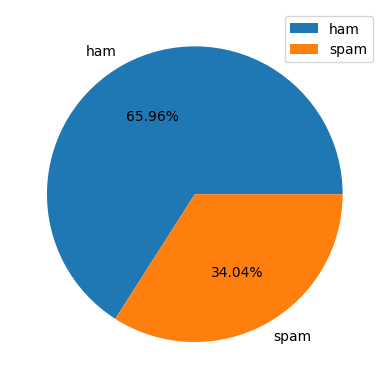

In [ ]:
plt.pie(df['Label'].value_counts(),labels = ['ham', 'spam'], autopct = "%.2f%%");
plt.legend();

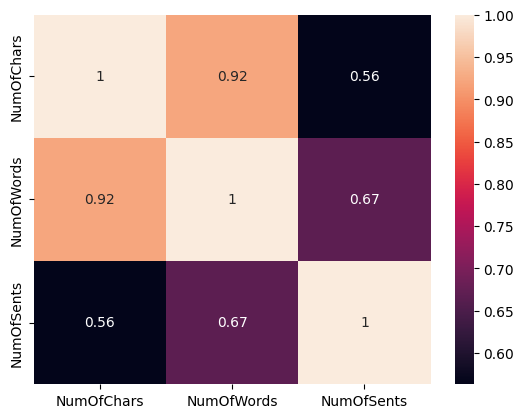

In [35]:
sns.heatmap(df[['NumOfChars', 'NumOfWords', 'NumOfSents']].corr(), annot = True);

<Axes: xlabel='NumOfChars', ylabel='Count'>

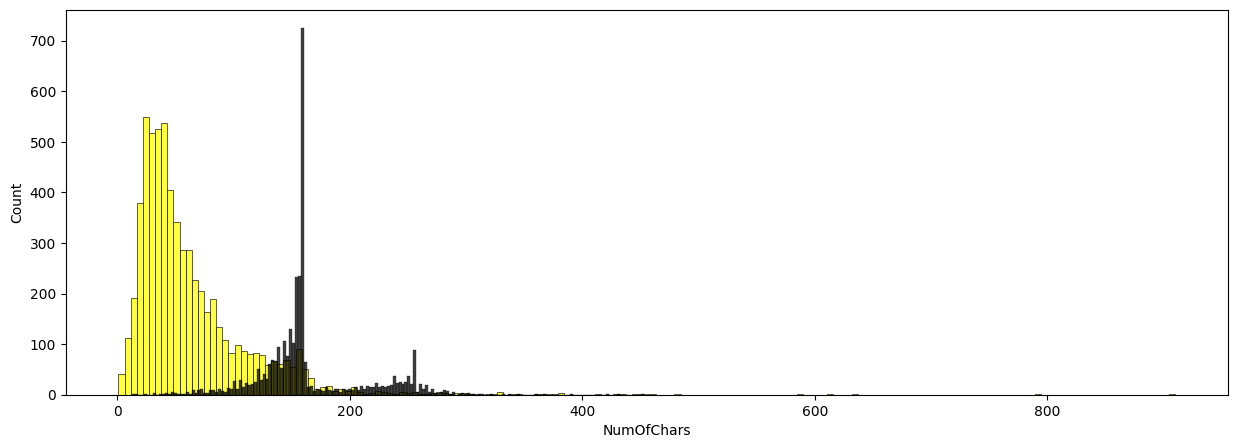

In [38]:
plt.figure(figsize = (15, 5))
sns.histplot(df[df['Label'] == "ham"]['NumOfChars'], color = "yellow")
sns.histplot(df[df['Label'] == "spam"]['NumOfChars'], color = "black")

<Axes: xlabel='NumOfWords', ylabel='Count'>

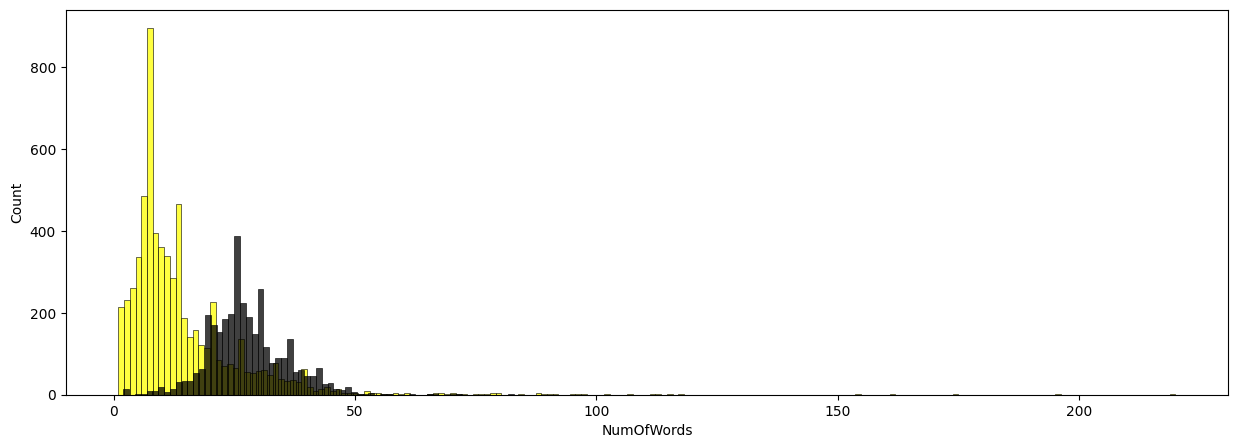

In [39]:
plt.figure(figsize = (15, 5))
sns.histplot(df[df['Label'] == "ham"]['NumOfWords'], color = "yellow")
sns.histplot(df[df['Label'] == "spam"]['NumOfWords'], color = "black")

<Axes: xlabel='NumOfSents', ylabel='Count'>

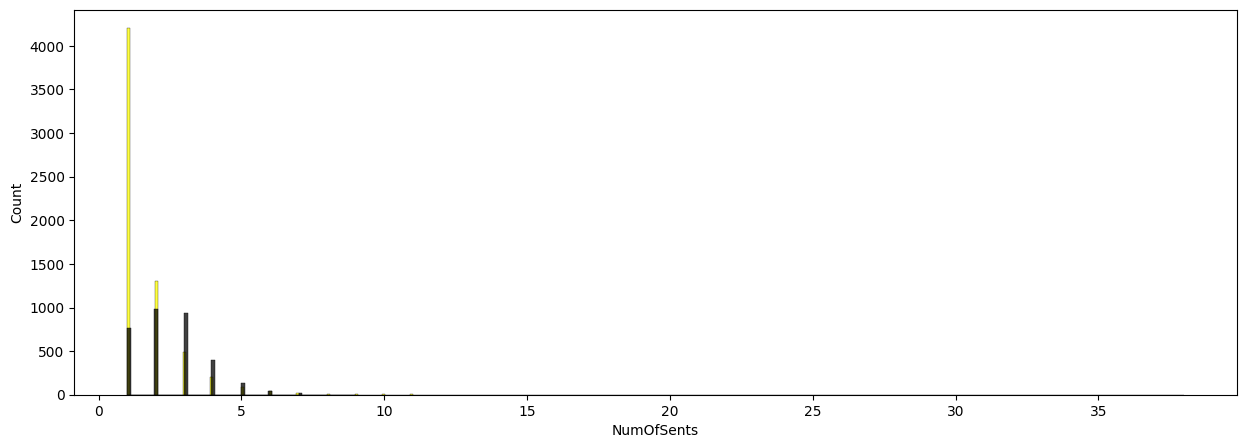

In [40]:
plt.figure(figsize = (15, 5))
sns.histplot(df[df['Label'] == "ham"]['NumOfSents'], color = "yellow")
sns.histplot(df[df['Label'] == "spam"]['NumOfSents'], color = "black")

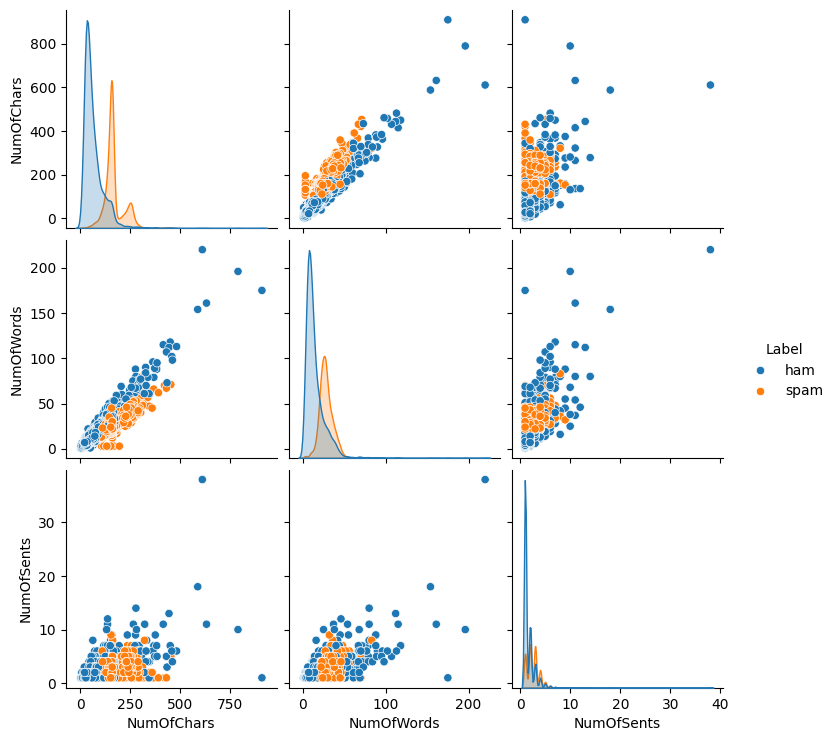

In [41]:
sns.pairplot(df, hue='Label')

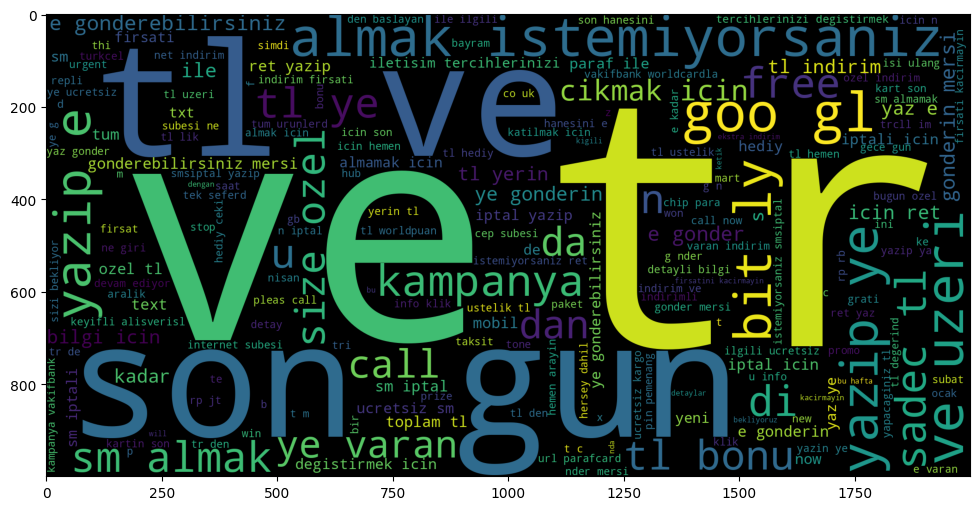

In [48]:
wc = WordCloud(width = 2000, height = 1000, min_font_size = 10, background_color = 'Black')
plt.figure(figsize = (15,6))
plt.imshow(wc.generate(df[df['Label']=='spam']['CleanMessage'].str.cat(sep = " ")));

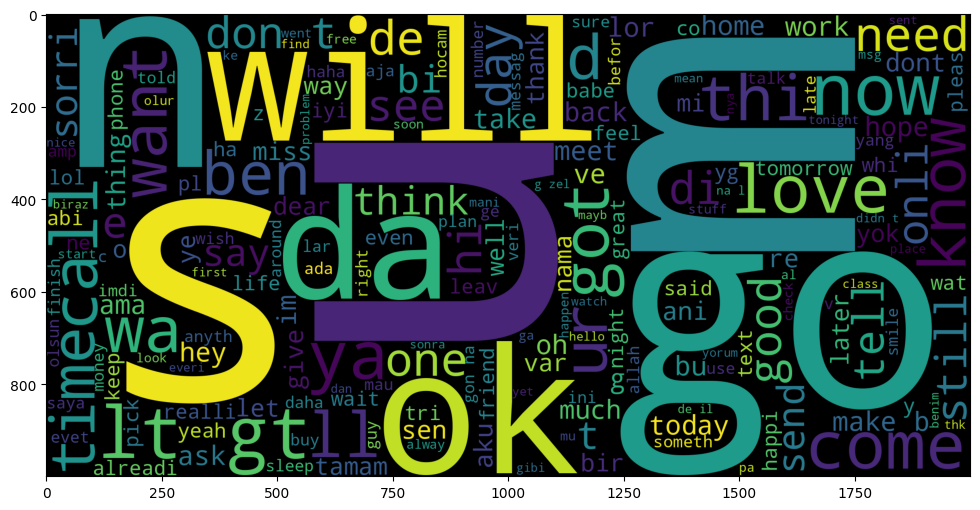

In [49]:
wc = WordCloud(width = 2000, height = 1000, min_font_size = 10, background_color = 'Black')
plt.figure(figsize = (15,6))
plt.imshow(wc.generate(df[df['Label']=='ham']['CleanMessage'].str.cat(sep = " ")));

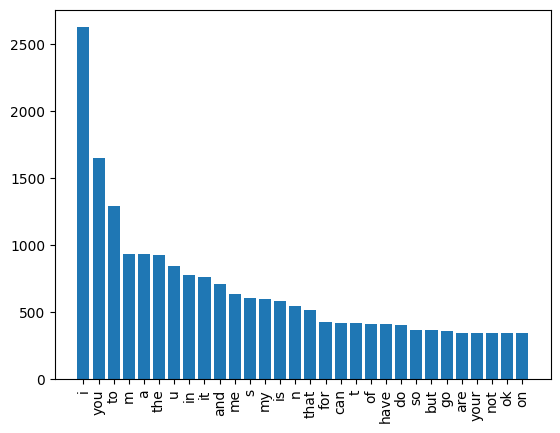

In [58]:
spam_words = get_word_count(df, "ham")
plt.bar(spam_words[0], spam_words[1])
plt.xticks(rotation = 'vertical');

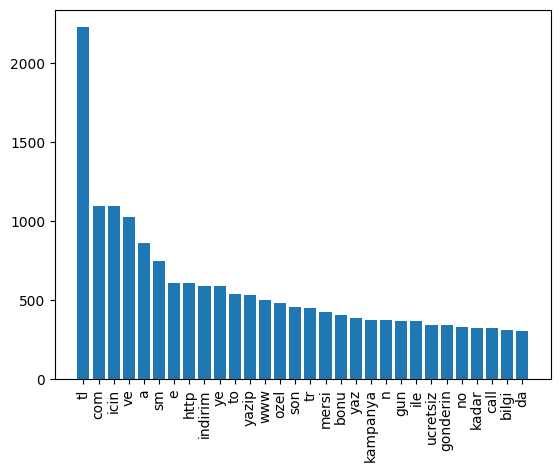

In [59]:
ham_words = get_word_count(df, "spam")

plt.bar(ham_words[0], ham_words[1])
plt.xticks(rotation = 'vertical');

##Methods Development

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import os


class ML_Models:
    def __init__(self, base_path):
        self.model_path = base_path
        self.initial_models = []
        self.models = {}
        self.initial_models.append(('LogisticRegression', LogisticRegression()) )
        self.initial_models.append(('DecisionTree', DecisionTreeClassifier()))
        self.initial_models.append(('RandomForest', RandomForestClassifier()))
        self.initial_models.append(('NaiveBayes', MultinomialNB()))
        self.initial_models.append(('KNN', KNeighborsClassifier()))
        self.initial_models.append(('SVM', SVC()))

    def set_data(self, X, y, test_size=0.3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 2)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def fit_models(self):
        models = []
        accuracy = []
        precision = []
        recall = []
        f1 = []
        for name, model in self.initial_models:
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            models.append(name)
            accuracy.append(round(accuracy_score(self.y_test, y_pred), 4) * 100)
            precision.append(round(precision_score(self.y_test, y_pred), 4) * 100)
            recall.append(round(recall_score(self.y_test, y_pred), 4) * 100)
            f1.append(round(f1_score(self.y_test, y_pred), 4) * 100)
            pickle.dump(model, open(os.path.join(self.model_path, name+'.pkl'), 'wb'))
            self.models[name] = model
        self.outputs = pd.DataFrame({'Model': models, 'Accuracy':accuracy, 'Precision':precision,
                   'Recall':recall, 'F1 Score':f1})
        self.outputs = self.outputs.sort_values(by = 'Accuracy', ascending = False).reset_index(drop = True)

    def get_outputs(self):
        return self.outputs

    def run(self, X, y):
        self.set_data(X, y)
        self.fit_models()
        print("TF-IDF + ML Models Outputs: \n", self.get_outputs())

    def delete_initial_model(self, model_name):
        self.initial_models = [model for model in self.initial_models if model[0] != model_name]

    def load_model(self, model_name):
        model = pickle.load(open(os.path.join(self.model_path, model_name+'.pkl'), 'rb'))
        self.models[model_name] = model

    def predict(self, model_name, X):
        return self.models[model_name].predict(X)

### TF-IDF + ML

In [57]:
X, y = prepare_data_for_method_ml('/content/sms_spam_train.csv')

Initial Data: 
                                              Message Label
0  Whats upp ac enisteee: -) senin memlekette bul...   ham
1  Kampanya, VakifBank Worldcardla 31 Mayisa kada...  spam
2                      I wont. So wat's wit the guys   ham
3                   Bu arada son dakika evi düşürdük   ham
4             No that just means you have a fat head   ham
Null data count for each column:
 Message    0
Label      0
dtype: int64

Dublicate Count:  332
Dublicate Count:  0
DataFrame Shape:  (9668, 2)

Percentage of Labels: 
 Label
ham     65.959868
spam    34.040132
Name: proportion, dtype: float64
All Data Describe:
         NumOfChars   NumOfWords   NumOfSents
count  9668.000000  9668.000000  9668.000000
mean     98.005792    18.751965     1.906185
std      69.832178    12.802917     1.289240
min       1.000000     1.000000     1.000000
25%      38.000000     8.000000     1.000000
50%      79.000000    17.000000     1.000000
75%     153.000000    27.000000     2.000000
max   

In [47]:
tf_idf_ml = ML_Models('/content/')
tf_idf_ml.run(X, y)

TF-IDF + ML Models Outputs: 
                 Model  Accuracy  Precision  Recall  F1 Score
0                 SVM     98.24      98.58   96.34     97.45
1        RandomForest     98.10      97.61   96.93     97.27
2  LogisticRegression     97.52      99.27   93.57     96.33
3        DecisionTree     96.00      93.83   94.76     94.29
4          NaiveBayes     95.69      96.44   91.00     93.64
5                 KNN     79.56     100.00   41.35     58.50


In [62]:
tf_idf_ml = ML_Models('/content/')
tf_idf_ml.load_model('LogisticRegression')

###Transformer + ML

In [37]:
X, y = prepare_data_for_transformer('/content/sms_spam_train.csv')

Initial Data: 
                                              Message Label
0  Whats upp ac enisteee: -) senin memlekette bul...   ham
1  Kampanya, VakifBank Worldcardla 31 Mayisa kada...  spam
2                      I wont. So wat's wit the guys   ham
3                   Bu arada son dakika evi düşürdük   ham
4             No that just means you have a fat head   ham
X shape:  (10000, 384)
y shape:  (10000,)


In [44]:
trf_ml = ML_Models('/content/')
trf_ml.delete_initial_model('NaiveBayes')
trf_ml.run(X, y)

TF-IDF + ML Models Outputs: 
                 Model  Accuracy  Precision  Recall  F1 Score
0                 SVM     98.43      98.81   96.60     97.69
1  LogisticRegression     97.73      97.15   96.21     96.68
2        RandomForest     96.77      98.54   91.93     95.12
3                 KNN     94.73      87.97   98.06     92.74
4        DecisionTree     89.23      83.94   84.84     84.39
